# 自製智能中文選字系統  (2)

In [ ]:
import sys
sys.version

'3.7.11 (default, Jul  3 2021, 18:01:19) \n[GCC 7.5.0]'

確認版本為 python3

## 資料前處理

In [ ]:
import re

In [ ]:
def prepocess_line(line):
    chinese_pattern = r'[\u4E00-\u9FFF]+'
    segments = re.findall(chinese_pattern, line, flags=re.UNICODE)
    return segments

In [ ]:
segments = []
with open('./wiki_zh_small.txt') as fr:
    for line in fr.readlines():
        segments += prepocess_line(line)

## 斷詞

In [ ]:
!pip install jieba

In [ ]:
import jieba

In [ ]:
list(jieba.cut_for_search(segments[6001]))

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.026 seconds.
Prefix dict has been built successfully.


['所以', '僅用', '於', '還原', '一些', '貴重', '的', '化合', '化合物']

In [ ]:
cut_segments = []
for seg in segments:
    # 使用結巴斷詞的 cut_for_search
    # YOUR CODE HERE
    cut_segments += jieba.lcut_for_search(seg)
    # END YOUR CODE
len(cut_segments)

222118

In [ ]:
cut_segments[:10]

['英語', '英語', '英語', '又', '稱', '爲', '英文', '是', '一種', '西']

## 使用斷詞的結果來作Ngram

In [ ]:
from collections import Counter

class Counters:
    def __init__(self, n):
        self.n = n
        self.counters = [Counter() for _ in range(n + 1)]

    def fit(self, segments):
        for i in range(1, 1 + self.n):
            for segment in segments:
                self.counters[i] += Counter(self._skip(segment, i))

        base_count = sum(dict(self.counters[1]).values())
        self.counters[0] = Counter({'': base_count})

    def __getitem__(self, k):
        return self.counters[k]

    def _skip(self, segment, n):
        assert n > 0
        if len(segment) < n:
            return []
        shift = n - 1
        for i in range(len(segment) - shift):
            yield segment[i:i+shift+1]

In [ ]:
counters = Counters(n=5)
counters.fit(cut_segments) 

In [ ]:
class Ngram:
    def __init__(self, n, counters):
        assert n <= counters.n
        self.n = n
        self.major_counter = counters[n]
        self.minor_counter = counters[n-1]

    def predict_proba(self, prefix='', top_k=5):
        assert len(prefix) >= self.n - 1

        reference = prefix[-(self.n - 1):] if self.n > 1 else ''
        count_referecne = self.minor_counter[reference]
        probs = []
        for key, count in dict(self.major_counter).items():
            if key.startswith(reference):
                prob = count / count_referecne
                probs.append((prob, key[-1]))
        sorted_probs = sorted(probs, reverse=True)
        return sorted_probs[:top_k] if top_k > 0 else sorted_probs

    def get_proba_dict(self, prefix=''):
        return {word: prob for prob, word in self.predict_proba(prefix, top_k=-1)}

In [ ]:
ngrams = [Ngram(i, counters) for i in range(1, 6)]

## 使用Smoothing of Language Models來建立第二版選字系統


### back-off smoothing: 
$\bar{P}_n = P_n$ if $P_n > 0$ else $aP_{n-1} $

$\bar{P}_n$: smoothed language model, if an n-gram based model yields a result of 0 at n, then the smoothed n-gram would yield a result of $aP_{n-1}$


### interpolation smoothing

$\bar{P}_n = \lambda P_n + (1-\lambda)\bar{P}_{n-1}$

For example, a 3-gram smoothed by interpolation would be :

$\bar{P}_3 = \lambda P_3 + (1-\lambda)\bar{P}_{2}$

where $\bar{P}_2$ is: 

$\lambda P_2 + (1-\lambda)\bar{P}_{1}$

In [ ]:
class ChineseWordRecommenderV2:
    def __init__(self, ngrams):
        self.ngrams = ngrams
    
    def predict_proba(self, prefix='', top_k=5):
        interpolation_lambda = 0.99
        proba_dicts = [ngram.get_proba_dict(prefix) for ngram in ngrams[:len(prefix)+1]]

        probas = []
        # 在此你可以選擇兩種 Smoothing of Language Models 的方法：
        # Back-off Smoothing 或 Interpolation Smoothing
        # 如果你選擇 Interpolation Smoothing，你可以運用已經準備好的輔助函式
        # _get_interpolation_proba 來達到此目的
        # YOUR CODE HERE
        for indv in proba_dicts[0].keys():
          probas.append((self._get_interpolation_proba(indv, proba_dicts, interpolation_lambda),indv))

        sorted_probas = sorted(probas, reverse = True)
        # END YOUR CODE
        return sorted_probas[:top_k] if top_k > 0 else sorted_probas
    
    def _get_interpolation_proba(self, word, proba_dicts, interp_lambda, idx=None):
        if idx is None:
            idx = len(proba_dicts) - 1
        if idx == 0:
            return proba_dicts[idx].get(word, 0.)
        return interp_lambda * proba_dicts[idx].get(word, 0.) + \
               (1 - interp_lambda) * self._get_interpolation_proba(word, proba_dicts, interp_lambda, idx=idx-1)
    def _get_bo_smoth(self,word,proba_dicts,a, idx = None):
      

In [ ]:
model = ChineseWordRecommenderV2(ngrams)

In [ ]:
probs = model.predict_proba('法', top_k=10)
probs

[(0.051904146168121834, '國'),
 (0.04388616116650217, '律'),
 (0.029848241612163377, '院'),
 (0.020222220928179165, '語'),
 (0.011414997351123958, '蘭'),
 (0.010549762034510142, '系'),
 (0.00792383560501087, '定'),
 (0.007908712635409567, '制'),
 (0.007072068387587443, '學'),
 (0.007060356996987107, '西')]

## Demo

In [ ]:
!pip install -U pip
!pip install -q ipywidgets

     |████████████████████████████████| 1.6 MB 5.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [ ]:
import ipywidgets as widgets

text = widgets.Textarea()
label = widgets.Label()
display(label, text)

def func(change):
    probs = model.predict_proba(change.new, top_k=10)
    label.value = ' ' + '\t'.join([word for prob, word in probs])

text.observe(func, names='value')

Label(value='')

Textarea(value='')

# execution result in Google collab

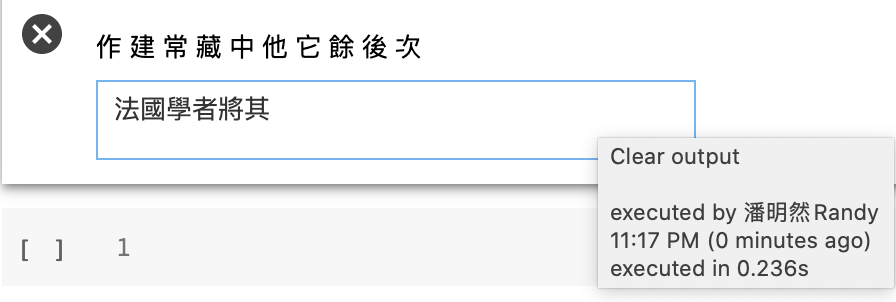